# Classifying the word 'Apple'

## Background

The objective of this excercise is to build an NLP model that can distinguish between apple-the fruit and Apple-the company. The test data shall consist of a number of sentences or paragraphs containing the word 'apple'. Based on the context, I am required to identify whether the sentence/paragraph refers to the fruit or the company. I have treated this problem as a binary classification problem. 

For training my model, I have been provided with two text files - "apple-computers.txt" and "apple-fruit.txt". For the purposes of this exercise, it is being assumed that these text files are available in the same directory from where this notebook is being executed.

The strategy for any NLP problem is to first convert the text to a numerical vector before the data can be fed into a model. Traditionally, the approach has been to use a vectorizer such as Tf-Idf vectorizer or Count vectorizer. Subsequently the vectorized dataset can be fed into a classical machine learning model such as Logistic Regression, Random Forest, Support Vector Machines, or a Naive Bayes Classifier. 

A vectorizer such as Tf-Idf or Count Vectorizer can only give as output the representation of text as a collection of words. However, for extracting meaning from sentences, the order of the words is as important as the words themselves. That is why, the approach of using Tf-Idf/Count Vectorizer followed by classical machine learning often do not give us the best results. A better approach is to use Word Embeddings followed by an Embedding vector which can be fed into a Neural network. It is possible to create your own Embedding vectors from scratch using neural network libraries. Alternatively, there are open source pre-trained word embeddings such as Word2Vec or more recently GloVe which can be utilized for creating the Embedding vector.

In this exercise I have used GloVe followed by LSTM which is a kind of Recurrent Neural Network. Glove embeddings were created by a Stanford research group and they are available in 4 different dimensions which are 50,100,200 and 300. For this exercise I have used a 100 dimensional embedding. In other words, each word is represented by a 100 dimension vector.

I will subsequently explain each of my steps in the following paragraphs.

In [1]:
import os
import pandas as pd
import numpy as np
import pickle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Flatten, LSTM, Bidirectional, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
from sklearn.metrics import confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
import string
import nltk
from nltk.stem import SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

Using TensorFlow backend.


## Pre-processing

Before performing any kind of vectorization or training, it is usually advisable to pre-process the text that can make model training easier. The pre-processing steps I would like to perform are as follows:

1. Identify if a word is an English stopword
2. Identify if the word is actually a punctuation mark
3. Convert all words to lower case. This ensures that words that start with capital letters on account of being at the start of a sentence do not get treated differently from when the same word appears in the middle of a sentence
4. Lemmatize the word to make sure it is in its base form (apples or Apple's gets transformed to apple)

I have created functions for identifying stopwords, punctuations, and for lemmatization. The function for lemmatization also converts the words to lowercase.

There are many libraries available for lemmatization. I have used <b>nltk</b>. 

In [2]:
def is_stopword(token):
    stops = stopwords.words('english').copy()
    return token in stops

def is_punctuation(token):
    return token in string.punctuation

In [3]:
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    output = []
    # read each sentence and lemmatize the words
    for sentence in text:
        words = word_tokenize(sentence.lower())
        tokens = [token for token in words if not(is_punctuation(token) or is_stopword(token))]
        lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in tokens])
        output.append(lemmatized_output)
        
    return output

## Reading the input files

I was provided with two text files - 1)<b> apple-computers.txt</b> and 2)<b> apple-fruit.txt</b>

The files were read assuming encoding 'utf-8'. The input file is split along newline characters ('\n') so that the output is a list with each element being a sentence or a paragraph. The 'lemmatize' function defined earlier is then applied to each sentence/paragraph. Subsequently, the output list consists of the lemmatized versions of all the sentences, converted to lowercase, and with all english stopwords and punctuations removed.

### Reading the apple-computer.txt file

The text file "apple-computers.txt" is read and lemmatized. Subsequently, I only retain those sentences that contain the word 'apple'.

In [4]:
with open("apple-computers.txt", encoding='utf-8') as f:
    lines = f.read()

    text_apple_inc = lines.split("\n")

In [5]:
text_apple_inc

['Apple Inc.',
 'From Wikipedia, the free encyclopedia',
 'This article is about the technology company. For other companies named "Apple", see Apple (disambiguation).',
 'Page semi-protected',
 'Coordinates: 37.33182°N 122.03118°W',
 'Apple Inc.',
 'Apple logo black.svg',
 'Logo used since 1998',
 'Type\tPublic',
 'Traded as\t',
 'NASDAQ: AAPL',
 'NASDAQ-100 component',
 'S&P 500 component',
 'Industry\t',
 'Computer hardware',
 'Computer software',
 'Consumer electronics',
 'Digital distribution',
 'Founded\tApril 1, 1976 (37 years ago)',
 '(incorporated January 3, 1977)',
 'Founder(s)\t',
 'Steve Jobs',
 'Steve Wozniak',
 'Ronald Wayne[1]',
 'Headquarters\tApple Campus, 1 Infinite Loop, Cupertino, California, U.S.[2]',
 'Number of locations\t406 retail stores (as of May 2013)',
 'Area served\tWorldwide',
 'Key people\tArthur D. Levinson (Chairman)[3]',
 'Tim Cook (CEO),',
 'Steve Jobs (Founder, former CEO)',
 'Products\t',
 'Products list[show]',
 'Services\t',
 'Services list[show]

In [6]:
text_apple_inc = lemmatize(text_apple_inc) # text is passed through the lemmatize function defined earlier

text_apple_inc = [ x for x in text_apple_inc if "apple" in x ] # Only sentences containing the word 'apple' are retained

text_apple_inc

['apple inc',
 "article technology company company named `` apple '' see apple disambiguation",
 'apple inc',
 'apple logo black.svg',
 'headquarters apple campus 1 infinite loop cupertino california u.s. 2',
 'website apple.com',
 'apple inc. formerly apple computer inc. american multinational corporation headquartered cupertino california 2 design develops sell consumer electronics computer software personal computer best-known hardware product mac line computer ipod music player iphone smartphone ipad tablet computer consumer software includes o x io operating system itunes medium browser safari web browser ilife iwork creativity productivity suite',
 "company founded april 1 1976 incorporated apple computer inc. january 3 1977 6 word `` computer '' removed name january 9 2007 day steve job introduced iphone reflecting shifted focus towards consumer electronics 7 8 9",
 "apple world 's second-largest information technology company revenue samsung electronics world 's third-largest m

### Reading the apple-computer.txt file

The text file "apple-fruit.txt" is read and lemmatized. Similar to the previous text, I only retain those sentences that contain the word 'apple'.

In [7]:
with open("apple-fruit.txt", encoding='utf-8') as f:
    lines = f.read()

text_apple_fruit = lines.split("\n")

In [8]:
text_apple_fruit

['This article is about the fruit. For the technology company, see Apple Inc.. For other uses, see Apple (disambiguation).',
 '"Apple tree" redirects here. For other uses, see Apple tree (disambiguation).',
 'Page semi-protectedThis is a good article. Click here for more information.',
 'Apple',
 '',
 'A typical apple',
 'Scientific classification',
 'Kingdom:\tPlantae',
 '(unranked):\tAngiosperms',
 '(unranked):\tEudicots',
 '(unranked):\tRosids',
 'Order:\tRosales',
 'Family:\tRosaceae',
 'Genus:\tMalus',
 'Species:\tM. domestica',
 'Binomial name',
 'Malus domestica',
 'Borkh., 1803',
 'Synonyms',
 'Malus communis Desf.',
 'Malus pumila auct.[1]',
 'Pyrus malus L.[2]',
 "The apple is the pomaceous fruit of the apple tree, species Malus domestica in the rose family (Rosaceae). It is one of the most widely cultivated tree fruits, and the most widely known of the many members of genus Malus that are used by humans. Apples grow on small, deciduous trees. The tree originated in Central A

In [9]:
text_apple_fruit = lemmatize(text_apple_fruit) # text is passed through the lemmatize function defined earlier

text_apple_fruit = [ x for x in text_apple_fruit if "apple" in x ] # Only sentences containing the word 'apple' are retained

text_apple_fruit

['article fruit technology company see apple inc.. us see apple disambiguation',
 "`` apple tree '' redirects us see apple tree disambiguation",
 'apple',
 'typical apple',
 "apple pomaceous fruit apple tree specie malus domestica rose family rosaceae one widely cultivated tree fruit widely known many member genus malus used human apple grow small deciduous tree tree originated central asia wild ancestor malus sieversii still found today apple grown thousand year asia europe brought north america european colonist apple present mythology religion many culture including norse greek christian tradition 2010 fruit 's genome decoded leading new understanding disease control selective breeding apple production",
 '7,500 known cultivar apple resulting range desired characteristic different cultivar bred various taste us including cooking fresh eating cider production domestic apple generally propagated grafting although wild apple grow readily seed tree prone number fungal bacterial pest pro

## Creating labels for training data

Before training the model, it is essential that the appropriate output labels are assigned against the texts in order to help us classify if a text refers to Apple the company or apple the fruit. For the purposes of this exercise, I have labeled texts that refer to Apple the company as 1, and those that refer to apple the fruit as 0.

I have assumed that every sentence/paragraph from the "apple-computers.txt" file, that contains the word 'apple' refers to Apple the company. Similarly, every sentence/paragraph from the "apple-fruit.txt" file, that contains the word 'apple' refers to apple the fruit.

In [10]:
label_apple_inc = [1]*len(text_apple_inc)
label_apple_fruit = [0]*len(text_apple_fruit)

In [11]:
texts = text_apple_inc + text_apple_fruit
labels = label_apple_inc + label_apple_fruit
labels_orig = np.array(labels)

In [12]:
print ("Total number of sentences with Apple computers are",(sum(labels_orig)))
print ("Total number of sentences with apple fruit are",(len(labels_orig) - sum(labels_orig)))

Total number of sentences with Apple computers are 176
Total number of sentences with apple fruit are 79


We notice that there are more than twice as many sentences for Apple computers than for apple the fruit. However, since the disparity is not something like an order of magnitude, we shouldn't necessarily treat this dataset as a skewed dataset. In situations where the data is overly skewed we would have looked at addressing it, but here it is not required.

## Tokenizing and sequencing the text

The next step before training a model is to tokenize and sequence the text input. The purpose of this step is to convert the text into a sequence of integers in an array. One is free to choose the maximum length of the array. I have chosen 1000. I have used keras for tokenizing and sequencing. 

The tokenizer is fit to the text corpus. The texts_to_sequences() method then converts each sentence to a sequence of integers. The sequences whose lengths are shorter than 1000 are padded.

Also, the labels array is converted to a tensor with each array having a length 2. For label 1, the representative array is [0 1]. For label 0, the representative array is [1 0]. Converting the labels array to a tensor makes it suitable to train the data in a neural network.

<b>An important step here is to save the tokenizer model. I have used pickle to save the tokenizer. If we ever need to test our subsequent neural network model on unseen test data, the test data (text) should be run through the same pre-processing steps and the tokenizer model before the neural netowrk model can be used on it.</b>

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=1000)
labels = to_categorical(np.asarray(labels_orig))
print('Shape of data tensor:', data.shape)
print('Shape of labels tensor:', labels.shape)

Found 3431 unique tokens.
Shape of data tensor: (255, 1000)
Shape of labels tensor: (255, 2)


In [14]:
word_index

{'apple': 1,
 "'s": 2,
 'company': 3,
 "''": 4,
 'also': 5,
 'new': 6,
 'iphone': 7,
 'job': 8,
 'year': 9,
 'product': 10,
 'computer': 11,
 'first': 12,
 'fruit': 13,
 'tree': 14,
 'store': 15,
 'mac': 16,
 'announced': 17,
 'inc': 18,
 '2012': 19,
 'time': 20,
 'ipad': 21,
 'used': 22,
 'introduced': 23,
 'market': 24,
 '4': 25,
 'would': 26,
 'software': 27,
 '2013': 28,
 'cultivar': 29,
 '2': 30,
 'may': 31,
 '2011': 32,
 'macintosh': 33,
 'ipod': 34,
 'one': 35,
 'variety': 36,
 'u': 37,
 'world': 38,
 'including': 39,
 '1': 40,
 'consumer': 41,
 'january': 42,
 '3': 43,
 '7': 44,
 'sold': 45,
 'video': 46,
 'share': 47,
 'million': 48,
 'released': 49,
 'o': 50,
 'steve': 51,
 'device': 52,
 'tv': 53,
 'october': 54,
 'state': 55,
 'model': 56,
 '5': 57,
 'since': 58,
 'later': 59,
 '2010': 60,
 'itunes': 61,
 'medium': 62,
 'user': 63,
 'microsoft': 64,
 'use': 65,
 'found': 66,
 'many': 67,
 'version': 68,
 'display': 69,
 'known': 70,
 'line': 71,
 'x': 72,
 'system': 73,
 '1

### Saving the tokenizer

I saved the tokenizer model as a "tokenizer.pickle" file. The file can be saved in the same directory that contains the notebook.

In [15]:
# saving tokenizer model
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Splitting the data into training and validation sets

In order to split the data into training and validation datasets we first shuffle the input data so that the input rows are now randomized. This is necessary because in our original dataset all the sentences for Apple computer come first and then all the sentences for apple fruit comes afterwards. If we do a straight split of the input data we might end up having a training dataset of all 1 and validation dataset of all 0.

In [16]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
labels_orig = labels_orig[np.array(indices)]
nb_validation_samples = int(0.3 * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
y_train_orig = labels_orig[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]
y_val_orig = labels_orig[-nb_validation_samples:]

In [17]:
print(np.array(indices))

[179 173  92 201 164   1 207 150   3 103 119 225  69 100 148  38  59  26
 170  30  36 105  14  40  62  65 177 136 242 145 149 108  61 144 250 147
  88 152  56  32 116  58 241 208 171 102  28 186 141 253 125  17  50  80
 184  60  77 185 156 216 142  46 196 114 209 110 134 115 183 193 158  96
  83 138 214 153 235 161 162 172  34 211 117 112 104  53 248 168 160 181
  63 230   6  64 127  91  12  81  89 245  86  48 118 224 233  13  37  95
 132  44 159 187 236  47 166 229  21 199 219 191 195 123  75 203 113 215
 197 234  71 120 178 194 124 155 204 227  70 226 107  82  49 189 251 146
  22 252  43 202 228 240   2  68 182 238  72  87 218 128  84 249 121 135
  52 220 192  97  57 205 101 157 133 198  16  74  39 174 247 243   7 231
 167 137  85 190 111  76  54 151  99 129  11 244  23  24 163  15  66 126
 237  18   4 210  45   5 154  73 180 169 254  98 221 246  27  67   0 213
 130   8 109  79 223  55  33 165 222  42 232  35 139 188 239  25  31 131
  93  90 176  41  19  20 206 200 140 122  78   9 21

In [18]:
x_train.shape

(179, 1000)

## Word embeddings and embedding matrix

The pre-trained word embeddings file for GloVe are extremely large in size. They can be downloaded from the Stanford NLP group's website. In order to do that, go to https://nlp.stanford.edu/projects/glove/. Underneath “Download pre-trained word vectors,” we have four available choices based on how large we want the embedding vectors to be and how large of a vocabulary we want the words to be trained on.
For this exercise, I chose the first option - the Wikipedia 2014 + Gigaword 5 vectors. These can be downloaded from http://nlp.stanford.edu/data/glove.6B.zip.

The zip file can be extracted and placed in the same directory as this notebook. If the downlaod and extraction go well, we should find a folder named 'glove' in our project directory. The 'glove' folder should have 4 files representing embeddings of different dimensions. For this work, I have used the embeddings of 100 dimension which are available in the file <b>'glove.6B.100d.txt'</b>.

In [19]:
embeddings_index = {}
f = open(os.path.join('glove', 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


### Creating an Embeddings matrix

Next, using the embedding vectors retrieved from the glove file, I create an embedding matrix. This matrix represents a collection of vectors corresponding to each word from the word_index dictionary that I created after training the tokenizer. In the word_index dictionary, words that are used most frequently are ranked higher, while words used less frequently are ranked lower. For giant text corpuses, we can sometimes use just the 1000 most or 2000 most frequently used words. However, in this exercise the total number of tokens (unique words) were low enough (3431 unique tokens) that I could choose to use the entire list.

In [20]:
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_matrix.shape

(3432, 100)

## Training the Neural Network model

Finally I am ready to train the classifier model. There are several possible approaches I could follow while creating my neural network. I wanted to use Bidirectional LSTM since these take into account the order of the words (vectors) in both directions forward and backward and thus are able to identify trends that are usually missed while using LSTM in a single direction.

At the outset, I add an embedding layer that assigns coefficients based on the embedding matrix.

Also, in order to reduce my training time, I added a Convolutional Neural Network layer followed by max pooling before applying LSTM. There are obviously many different combinations of these layers that could be used but this is one approach that has given me good results.

I limited the number of epochs (number of times the data is passed forward and backward through the neural network) to 20. With each epoch, the loss function gets smaller and smaller. An Adam optimizer has been used for learning rate optimization. 

In [21]:
model_lstm = Sequential()
model_lstm.add(Embedding(len(word_index) + 1, 100, input_length=1000, weights=[embedding_matrix], trainable=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(Conv1D(64, 5, activation='relu'))
model_lstm.add(MaxPooling1D(pool_size=4))
model_lstm.add(Bidirectional(LSTM(100)))
model_lstm.add(Dense(2, activation='sigmoid'))
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
## Fit train data
model_lstm.fit(x_train, y_train, validation_data=(x_val, y_val), epochs = 20)











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 179 samples, validate on 76 samples
Epoch 1/20
179/179 [==============================] - 16s 90ms/step - loss: 0.6361 - acc: 0.6564 - val_loss: 0.5576 - val_acc: 0.7368
Epoch 2/20
179/179 [==============================] - 10s 55ms/step - loss: 0.5444 - acc: 0.6732 - val_loss: 0.4892 - val_acc: 0.7500
Epoch 3/20
179/179 [==============================] - 10s 55ms/step - loss: 0.4185 - acc: 0.7933 - val_loss: 0.3639 - val_acc: 0.8684
Epoch 4/20
179/179 [==============================] - 10s 55ms/step - loss: 0.2635 - acc: 0.9358 - val_loss: 0.2649 - val_acc: 0.9013
Epoch 5/20
179/179 [==============================] - 10s 55ms/step - loss: 0.1608 - acc: 0.9581 - val_loss: 0.1979 - val_acc: 0.9539
Epoch 6/20
179/179 [==============================] - 10s 55m

## Cross validation results

As seen above, after the 20th epoch, I'm getting a 100% accuracy on my training dataset and close to 95% accuracy on my validation data. I also wanted to look at the confusion matrix for the validation dataset. Keep in mind that label 1 refers to 'Apple computer' while label 0 refers to 'apple fruit'

As seen below, the model does well in classifying between the two kinds of apples. The number of false positives and false negatives are also negligible.

[[17  3]
 [ 1 55]]


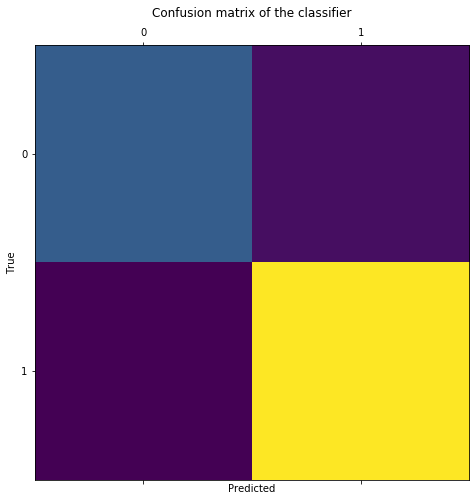

In [22]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 8]

predictions_val = model_lstm.predict_classes(x_val)

cm = confusion_matrix(y_val_orig, predictions_val)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Saving the Neural network model

Similar to the tokenizer, we must save the trained neural network model to disk as well for future use. This way, when we receive test data, we only need to load the model and run the test data through that model. If we want to expose an API which takes in test data and outputs the classification results, then loading the model should be one of the steps within that API.

Saving a neural network model entails 2 steps: 1) the model itself which tells us details about each layer, 2) the weights and coefficients corresponding to the neurons. These are saved in 2 different files and can be subsequently loaded as needed.

In [23]:
model_json = model_lstm.to_json() # serialize model to JSON

with open("model.json", "w") as json_file:
    json_file.write(model_json)

model_lstm.save_weights("model.h5") # serialize weights to HDF5

print("Model saved")

Model saved


## Testing new data

The test file is described as follows:

1. The first line of the file will contain an integer N that tells us how many individual sentences/paragraphs the test file contains
2. Each subsequent line and upto N lines will contain a sentence or a paragraph with the word 'apple' in it.

My function should be able to take in the test file, let's call it "Test.txt" and return the results such that we have 1 result per line. For example,

<b>computer-company
fruit
computer-company</b>

when the first sentece/paragraph refers to Apple Inc, second refers to apple the fruit, and 3rd refers to Apple Inc.

For testing the data, I need to first load the tokenizer model and the neural network model with weights. Once loaded, the test data is passed through these models so they are first tokenized and subsequently the classification result is given out.

<b>Similar to the training text files, I will assume here that the test file "Test.txt" is also available in the same directory from where the notebook is being executed.

Finally, the output is both printed here in the console, as well as saved into disk with the name "output_predictions.txt". Again, this output file will be saved in the same directory as the notebook.</b>

In [24]:
def classify_sentences(input_file):
    with open("Test.txt", encoding='utf-8') as f:
        N = f.readline()

    N = int(N)
    if N > 100:
        N = 100

    print("Number of lines:", N)

    with open("Test.txt", encoding='utf-8') as fin:
        lines = (fin.readlines()[1:N+1])

    test_data = []
    for i in range(len(lines)):
        test_data.append(lines[i].strip('\n'))

    test_data = lemmatize(test_data)
    
    print(" ")
    print(test_data)
    
    # loading tokenizer model
    with open('tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)

    sequences = tokenizer.texts_to_sequences(test_data)

    test_data_seq = pad_sequences(sequences, maxlen=1000)

    # loading neural network model

    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    loaded_model.load_weights("model.h5") # loading weights into the model

    print(" ")
    print("Models loaded")
    print(" ")
    
    predictions = loaded_model.predict_classes(test_data_seq)

    
    prediction_list = []

    for i in predictions:
        if i == 0:
            print ('fruit')
            prediction_list.append('fruit')
        elif i == 1:
            print ('computer-company')
            prediction_list.append('computer-company')
            
    with open('output_predictions.txt', mode='wt', encoding='utf-8') as output_predictions:
        output_predictions.write('\n'.join(prediction_list))

### Passing a test file to the function

Below, we call the newly created function for testing our model, and pass the "Test.txt" file to the model. The output is printed below in the console and is also saved as "output_predictions.txt" file.

In [25]:
classify_sentences("Test.txt")

Number of lines: 3
 
["apple already plan buy back 100 billion share including 16 billion worth last quarter icahn probably pounded dinner table cook shared recently much-reported bread-breaking icahn 's new york apartment apple 's cash stash currently sits whopping 145 billion 43 billion u.s. icahn want float bond cover buy back", 'fortunately “ low-chill ” apple variety temperate climate chilling hour defined nonconsecutive hour winter temperature 45 degree general guide live near coast garden get 100 200 chilling hour inland san diego garden get 400 500 chilling hour — still considered “ low chill ”', 'seems bit like déjà vu ’ recall apple held event unveil two new iphone model – 5c 5 – back september 10']
 
Models loaded
 
computer-company
fruit
computer-company
